In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from datetime import datetime
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt

C:\Users\Rakshith\Miniconda3\envs\machinelearning\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train = pd.read_csv("datasets/train.csv")
test = pd.read_csv("datasets/test.csv")

In [3]:
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [4]:
test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [5]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [6]:
train.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [7]:
test.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
dtype: int64

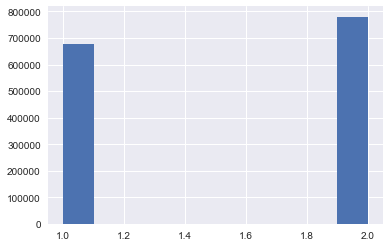

In [8]:
train['vendor_id'].hist()

In [9]:
train['vendor_id'].value_counts()

2    780302
1    678342
Name: vendor_id, dtype: int64

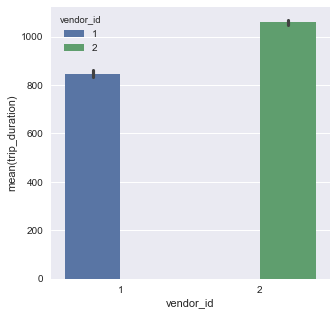

In [10]:
# vendorid having 2 seems to have a larger duration
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='vendor_id',y='trip_duration',hue='vendor_id')

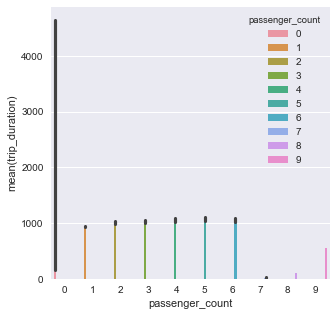

In [11]:
# Number of people fom 1 to 6 almost have same time to travel as opposed to 7 to 9.
fig,axes = plt.subplots(figsize = (5,5))
sns.barplot(data=train, x='passenger_count',y='trip_duration',hue='passenger_count')

NYC Border limits are such that 
city_long_border = (-74.03, -73.75) city_lat_border = (40.63, 40.85)
With that being defined, the rest of the other points we could sufficiently assume other datapoints are outliers.

In [12]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [13]:
train.shape

(1439183, 11)

In [14]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
print("Mean: {:.3f}  Standard Dev:{:.3f}".format(m,s))
Train = train[train['trip_duration'] <= m + 2*s]
Train = train[train['trip_duration'] >= m - 2*s]

Mean: 946.231  Standard Dev:5251.641


In [15]:
Train.shape

(1439183, 11)

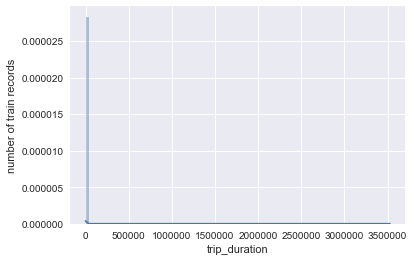

In [16]:
sns.distplot(a=train['trip_duration'],bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

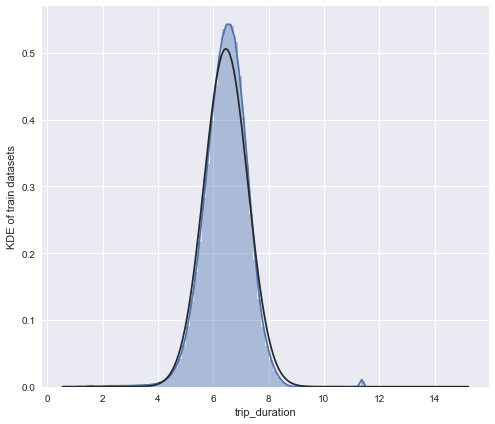

In [17]:
fig,axes = plt.subplots(figsize=(8,7))
plt.ylabel('KDE of train datasets')
plt.xlabel('log of Trip Duration')
sns.distplot(a=np.log1p(Train['trip_duration']),bins=100, fit=stats.norm)

In [18]:
Train['log_trip_duration'] = np.log1p(Train['trip_duration'])

In [19]:
Test = test

In [ ]:
Train['pickup_datetime_converted'] =pd.to_datetime(Train['pickup_datetime']) 
Test['pickup_datetime_converted'] =pd.to_datetime(Test['pickup_datetime']) 

In [ ]:
Train.loc[:, 'pickup_date'] = Train['pickup_datetime_converted'].dt.date
Test.loc[:, 'pickup_date'] = Test['pickup_datetime_converted'].dt.date

In [ ]:
fig,axes = plt.subplots(figsize =(16,8))
plt.plot(Train.groupby('pickup_date').count()[['id']], 'x-', label='train')
plt.plot(Test.groupby('pickup_date').count()[['id']], 'x-', label='test')
plt.title('Pickups over given time frame.')
plt.legend(loc=0)
plt.ylabel('Number of pickups')

In [ ]:
Train.head()

In [ ]:
Train.groupby('vendor_id')['trip_duration'].mean()

In [ ]:
Train.groupby('store_and_fwd_flag')['trip_duration'].mean()

In [ ]:
Train.groupby('passenger_count')['trip_duration'].mean()

In [ ]:
Train.groupby('passenger_count').size()

In [ ]:
sns.lmplot(x='pickup_latitude',y = 'pickup_latitude',fit_reg=False,data=Train)

In [ ]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True)
ax[0].scatter(Train['pickup_longitude'].values[:N], Train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(Test['pickup_longitude'].values[:N], Test['pickup_latitude'].values[:N],
              color='green', s=1,label='test', alpha=0.1)
fig.suptitle('Train and test.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('longitude')
ax[1].legend(loc=0)
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [ ]:
Train.loc[:, 'distance_haversine'] = haversine_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_haversine'] = haversine_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)    
    
Train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

Train.loc[:, 'direction'] = bearing_array(Train['pickup_latitude'].values, Train['pickup_longitude'].values, Train['dropoff_latitude'].values, Train['dropoff_longitude'].values)
Test.loc[:, 'direction'] = bearing_array(Test['pickup_latitude'].values, Test['pickup_longitude'].values, Test['dropoff_latitude'].values, Test['dropoff_longitude'].values)

In [ ]:
Train

In [ ]:
Test

In [ ]:
fig,axes = plt.subplots()
axes.scatter(x=Train['distance_haversine'].values,y=Train['trip_duration'].values)
plt.xlabel("Haversine Distance")
plt.ylabel("Duration")

In [ ]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [ ]:
coords

In [ ]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [ ]:
Train.loc[:, 'pickup_cluster'] = kmeans.predict(Train[['pickup_latitude', 'pickup_longitude']])
Train.loc[:, 'dropoff_cluster'] = kmeans.predict(Train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

In [ ]:
Train.head()

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(Train.pickup_longitude.values[:500000], Train.pickup_latitude.values[:500000], s=10, lw=0,
           c=Train.pickup_cluster[:500000].values, cmap='autumn', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [ ]:
Train['Month'] = Train['pickup_datetime_converted'].dt.month
test['Month'] = test['pickup_datetime_converted'].dt.month

In [ ]:
Train.groupby('Month').count()['id'],test.groupby('Month').count()['id']

In [ ]:
fig,axes = plt.subplots()
axes.scatter(x=Train['distance_dummy_manhattan'].values,y=Train['trip_duration'].values)
plt.xlabel("Manhattan Distance")
plt.ylabel("Trip Duration")

In [ ]:
Train['Day'] = Train['pickup_datetime_converted'].dt.day
test['Day'] = test['pickup_datetime_converted'].dt.day

In [ ]:
Train.head()

In [ ]:
Train['Hour'] = Train['pickup_datetime_converted'].dt.hour
test['Hour'] = test['pickup_datetime_converted'].dt.hour

In [ ]:
Train.head()

In [ ]:
Train.groupby('Day').size() , test.groupby('Day').size()

In [ ]:
Train['Hour'].value_counts().sort_index(ascending = True),test['Hour'].value_counts().sort_index(ascending = True)


In [ ]:
plt.hist(Train['Hour'])

In [ ]:
fig, axes = plt.subplots(ncols=2,nrows=1,sharey=True,figsize=(14,8))
axes[0].scatter(Train['Hour'].value_counts().index,Train['Hour'].value_counts().values)
axes[1].plot(Train['Hour'].value_counts().index,Train['Hour'].value_counts().values)

In [ ]:
Train['h_average_speed'] = 1000 * Train['distance_haversine']/Train['trip_duration']
Train['m_avg_speed'] = 1000 * Train['distance_dummy_manhattan'] / train['trip_duration']

In [ ]:
Train['m_avg_speed']

In [ ]:
fig, ax = plt.subplots(ncols=3, sharey=True,figsize=(14,6))
ax[0].plot(Train.groupby('Hour').mean()['h_average_speed'], 'bo-', lw=2, alpha=0.7)
ax[1].plot(Train.groupby('Day').mean()['h_average_speed'], 'go-', lw=2, alpha=0.7)
ax[2].plot(Train.groupby('Month').mean()['h_average_speed'], 'ro-', lw=2, alpha=0.7)
ax[0].set_xlabel('Hour')
ax[1].set_xlabel('weekday')
ax[2].set_xlabel('Month')
ax[0].set_ylabel('average speed')
fig.suptitle('Rush hour average traffic speed')
plt.show()

In [ ]:
plt.plot(Train.groupby('Day').mean()['h_average_speed'])

In [ ]:
fig,axes = plt.subplots(figsize=(12,8))
plt.plot(Train.groupby('pickup_cluster').mean()['h_average_speed'])

In [ ]:
fig,axes = plt.subplots(figsize=(12,8))
plt.plot(Train.groupby('dropoff_cluster').mean()['h_average_speed'])

In [ ]:
Train['pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
Train['pickup_long_bin'] = np.round(train['pickup_longitude'], 3)